# LogGabor user guide


Table of content
----------------

* [What is the LogGabor package?](LogGabor.ipynb#What-is-the-LogGabor-package?) 

* [Installing](LogGabor.ipynb#Install) 

* [Importing the library](LogGabor.ipynb#Importing-the-library)

* [Properties of log-Gabor filters](LogGabor.ipynb#Properties-of-log-Gabor-filters)

* [Testing filter generation](#Testing-filter-generation) 

* [Testing on a sample image](LogGabor.ipynb#Testing-on-a-sample-image) 

* [Building a pyramid](LogGabor-making-a-pyramid.ipynb) 

* [An example of fitting images with log-Gabor filters](LogGabor_fit_example.ipynb) 

## Importing the library

In [1]:
%load_ext autoreload
%autoreload 2
from LogGabor import LogGabor
parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
lg = LogGabor(parameterfile)

To install the dependencies related to running this notebook, see [Installing notebook dependencies](#Installing-notebook-dependencies).

[Back to top](#LogGabor-user-guide)

In [2]:
import holoviews as hv
#hv.notebook_extension('bokeh')
%load_ext holoviews.ipython
%output size=150 dpi=120
%load_ext autoreload
%autoreload 2
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
fig_width = 12
figsize=(fig_width, .618*fig_width)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Testing filter generation

Here, we will generate some LogGabor filters.

Defining a reference log-gabor  (look in the corners!)

In [3]:
sf_0 = .02 # TODO .1 cycle / pixel (Geisler)
params= {'sf_0':sf_0, 'B_sf': lg.pe.B_sf, 'theta':0., 'B_theta': lg.pe.B_theta}

In [4]:
%opts Image (cmap='gray')
%opts Image.Fourier_domain (cmap='hot')

In [5]:
def fourier_domain(arr):
    return hv.Image(arr, group='Fourier domain',
                 key_dimensions=[r'$f_Y$', r'$f_X$'],
                 value_dimensions=[hv.Dimension('Fourier', range=(0,0.01))])
def image_domain(arr):
    return hv.Image(arr,group='Image domain',
                 key_dimensions=[r'$Y$', r'$X$'],
                 value_dimensions=[hv.Dimension('Image', range=(-1,1))])

:Layout
   .Fourier_domain.I :Image   [x,y]   (z)
   .Image_domain.I   :Image   [x,y]   (z)
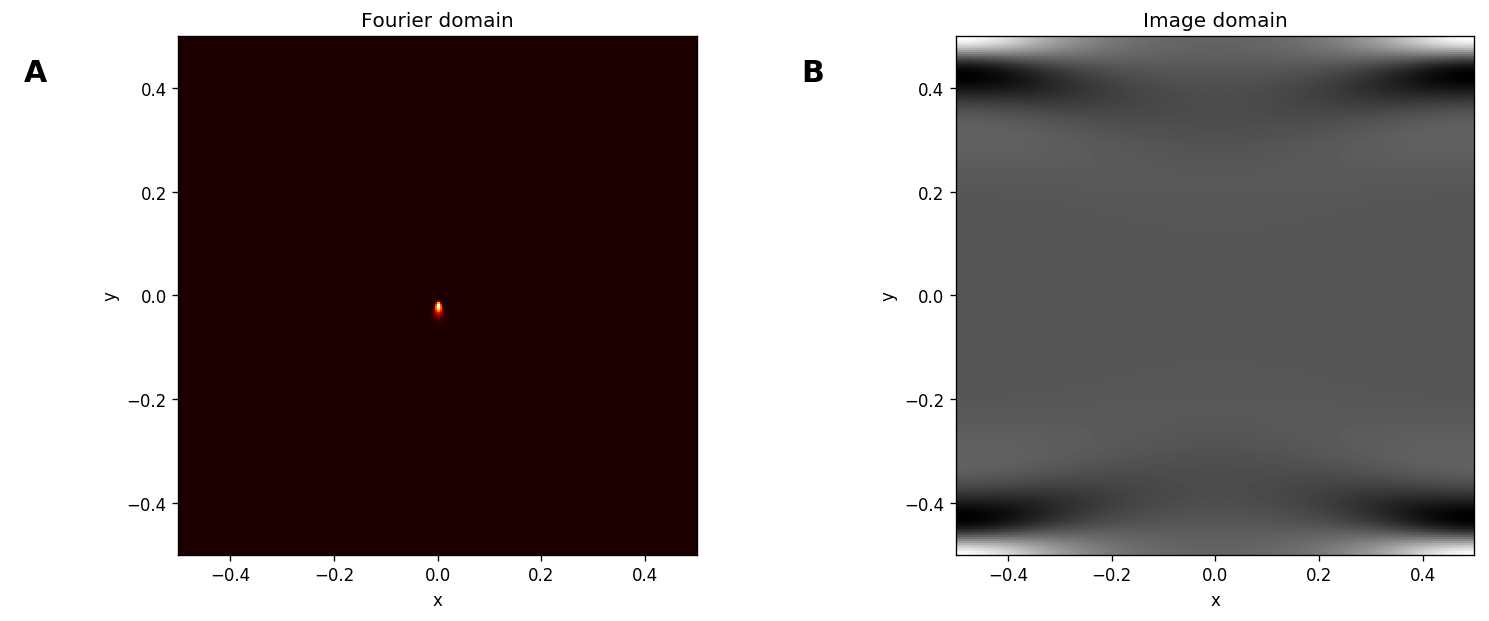

In [6]:
FT_lg = lg.loggabor(0, 0, **params)
(fourier_domain(lg.normalize(np.absolute(FT_lg), center=False))
+ image_domain(lg.normalize(lg.invert(FT_lg), center=False)))

Translating in the middle:

In [7]:
N_X, N_Y = image.shape
help(lg.translate)

NameError: name 'image' is not defined

same params, larger frequency with sf_0

In [ ]:
params2 = {'sf_0':sf_0*4, 'B_sf':lg.pe.B_sf, 'theta':0., 'B_theta':lg.pe.B_theta}
FT_lg = lg.loggabor(N_X/2, N_Y/2, **params2)
(fourier_domain(lg.normalize(np.absolute(FT_lg), center=False))
+ image_domain(lg.normalize(lg.invert(FT_lg), center=False)))

Same params, but larger frequency with sf_0

In [ ]:
params2 = {'sf_0':sf_0*4, 'B_sf':lg.pe.B_sf, 'theta':0., 'B_theta':lg.pe.B_theta}

In [ ]:
FT_lg = lg.loggabor(N_X/4, N_Y/2, **params2)
(fourier_domain(lg.normalize(np.absolute(FT_lg), center=False))
+ image_domain(lg.normalize(lg.invert(FT_lg), center=False)))

Narrower with a smaller B_theta:

In [ ]:
params3 = {'sf_0':sf_0, 'B_sf':lg.pe.B_sf, 'theta':0., 'B_theta':lg.pe.B_theta/2}
FT_lg = lg.loggabor(N_X/4, 3*N_Y/4, **params3)
(fourier_domain(lg.normalize(np.absolute(FT_lg), center=False))
+ image_domain(lg.normalize(lg.invert(FT_lg), center=False)))

Broader spectrum with B_sf

In [ ]:
params4 = {'sf_0':sf_0, 'B_sf':lg.pe.B_sf*2., 'theta':0., 'B_theta':lg.pe.B_theta}
FT_lg = lg.loggabor(N_X/4, N_Y/4, **params4)
(fourier_domain(lg.normalize(np.absolute(FT_lg), center=False))
+ image_domain(lg.normalize(lg.invert(FT_lg), center=False)))

Using a function to explore these parameters:

In [ ]:
def lg_explore(param_name, param_range, angle=False, movie=True):
    if movie:
        amp_map, phase_map = hv.HoloMap(), hv.HoloMap()
    else:
        ims = []
    for param_ in param_range:
        if angle:
            title = np.str(param_*180/np.pi) + r'$^0$'
        else:
            title = np.str(param_)
        if param_name=='phase':
            FT_phase = np.exp(-1j*param_)
            params_=params.copy()
        else:
            FT_phase = 1
            params_=params.copy()
            params_.update({param_name:param_})
        FT_lg = lg.loggabor(N_X/2, N_Y/2, **params_) * FT_phase
        
        amp =   fourier_domain(lg.normalize(np.absolute(FT_lg), center=False))
        phase = image_domain(lg.normalize(lg.invert(FT_lg),  center=False))
        
        if movie:
            amp_map[param_] = amp
            phase_map[param_] = phase
        else:
            ims.append((amp + phase))
    if movie:
        return amp_map + phase_map
    else:
        return np.sum(ims).cols(2)

Now exploring these parameters individually:

In [ ]:
lg_explore(param_name='phase', 
           param_range=np.linspace(0, np.pi, 24, endpoint=False), angle=True)

In [ ]:
lg_explore(param_name='theta', 
           param_range=lg.theta, 
           angle=True)

In [ ]:
lg_explore(param_name='B_theta', 
           param_range=lg.pe.B_theta*np.logspace(-.3, .2, 6), angle=True)

Here, we define a pyramid by defining a vector of ``sf_0`` values that we use later in Matching Pursuit (see https://github.com/bicv/SparseEdges):

In [ ]:
#n_levels = int(np.log(np.max((lg.pe.N_X, lg.pe.N_Y)))/np.log(lg.pe.base_levels))
print('for an image of size', np.max((lg.pe.N_X, lg.pe.N_Y)), ', at base lg.pe.base_levels=', lg.pe.base_levels, ', we have n_levels=', lg.n_levels)
#v_sf_0 = .5 * (1 - 1/n_levels) / np.logspace(0, n_levels, n_levels, base=lg.pe.base_levels)[::-1]
print('Range of spatial frequencies (in cycles per image pixel) =', lg.sf_0)
print('Range of spatial frequencies (in pixels per cycle) =', 1./lg.sf_0)
print('Range of spatial frequencies (in cycles per image size) =', lg.pe.N_X * lg.sf_0)
lg_explore(param_name='sf_0', param_range=lg.sf_0)

geometric mean distances across frequencies :

In [ ]:
scaling = np.sqrt(lg.sf_0[:, np.newaxis]*lg.sf_0[np.newaxis, :])
print('mean scaling=', scaling.mean())

In [ ]:
lg_explore(param_name='B_sf', param_range=lg.pe.B_sf*np.logspace(-.6, .6, 9))

[Back to top](#LogGabor-user-guide)

## more book keeping

In [ ]:
%load_ext watermark
%watermark

In [ ]:
%load_ext version_information
%version_information numpy, scipy, matplotlib, sympy, SLIP, LogGabor

[Back to top](#LogGabor-user-guide)
[Back to the LogGabor user guide](LogGabor.ipynb#LogGabor-user-guide)